# Softmax回归 + 损失函数 + 图片分类数据集

## 1. 图像分类数据集
MNIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。我们将使用类似但更加复杂的Fashion-MNIST数据集

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms  #对数据进行操作的包
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
# 通过ToTensor实例将图像数据从PIL转化为32位float格式
# 并且除以了255使得所有像素的值都在0-1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data",
                                                train=True,
                                                transform=trans,
												download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data",
                                            train=False,
                                            transform=trans,
											download=True)
len(mnist_train), len(mnist_test)

/home/xiaozhoua/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(60000, 10000)

In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [4]:
def get_fashion_mnist_labels(labels):
	"""生成对应的标签"""
	text_labels = [
		't-shirt', 'trouser', 'pullover', 'dress', 'coat',
		'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
	]
	return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.0):
	"Plot a list of image"
	figsize = (num_cols * scale, num_rows * scale)
	_, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
	axes = axes.flatten()
	for i, (ax, img) in enumerate(zip(axes, imgs)):
		if torch.is_tensor(img):
			ax.imshow(img.numpy())
		else:
			# PIL图片
			ax.imshow(img)
		ax.axes.get_xaxis().set_visible(False)
		ax.axes.get_yaxis().set_visible(False)
		if titles:
			ax.set_title(titles[i])
	return axes

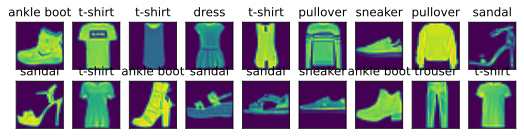

In [5]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [6]:
# 读取小批量数据，大小为batch_size
batch_size = 256
def get_dataloader_workers():
	"""使用4个进程来读取得数据"""
	return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
							num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X, y in train_iter:
	continue
f'{timer.stop():.2f} sec'

'11.23 sec'

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):
	trans = [transforms.ToTensor()]
	if resize:
		trans.insert(0, transforms.Resize(resize))
	trans = transforms.Compose(trans)
	# 加载数据集
	mnist_train = torchvision.datasets.FashionMNIST(root="./data",
													train=True,
													transform=trans,
													download=True)
	mnist_test = torchvision.datasets.FashionMNIST(root="./data",
												train=False,
												transform=trans,
												download=True)
	return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 2. softmax回归的从零开始实现

In [ ]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [ ]:
num_inputs = 784
num_outputs = 10

# 初始化权重和偏置
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
# 定义softmax操作
def softmax(X):
	X_exp = torch.exp(X)
	partition = X_exp.sum(1, keepdim=True)
	return X_exp/partition

In [ ]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0919, 0.2125, 0.1499, 0.4132, 0.1325],
         [0.0436, 0.0340, 0.5136, 0.2513, 0.1575]]),
 tensor([1., 1.]))

In [ ]:
# 定义模型
def net(X):
	return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [ ]:
#定义损失函数
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [ ]:
def accuracy(y_hat, y):
	if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
		y_hat = y_hat.argmax(axis=1)
	cmp = y_hat.type(y.dtype) == y
	return float(cmp.type(y.dtype).sum())

In [ ]:
accuracy(y_hat, y) / len(y)

0.5

In [ ]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
evaluate_accuracy(net, test_iter)

0.0333

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）。"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10

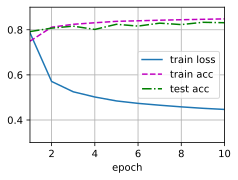

In [ ]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

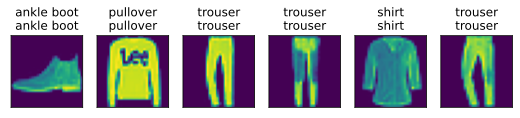

In [ ]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 3. softmax回归的简洁实现

In [9]:
import torch
from torch import nn
from d2l import torch as d2l


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [10]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10))

def init_weight(m):
	# 初始化函数
	if type(m) == nn.Linear:
		# 如果是Linear层将这一层的初始值改变
		nn.init.normal_(m.weight, std=0.01)
net.apply(init_weight);

In [11]:
loss = nn.CrossEntropyLoss()  # 损失函数
trainer = torch.optim.SGD(net.parameters(), lr=0.1)      # 优化器

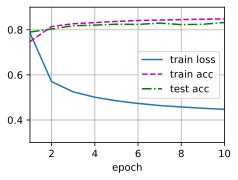

In [12]:
num_epochs =10;
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)